## Step 1:- Importing libraries

In [192]:
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.models import Sequential, load_model
from keras.layers import LSTM
from keras.layers.core import Dense, Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import heapq

## Step 2:- Loading the dataset

In [193]:
path = '/kaggle/input/corpus/data.txt'
text = open(path).read().lower()

## Step 3:- Using tokenizers

In [194]:
# tokenizer = RegexpTokenizer(r'w+')
# words = tokenizer.tokenize(text)


## Step 4:- Getting Unique Words

In [195]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 43


## Step 5:- Applying feature engineering to convert words to numerical representation

In [196]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 8341


## Step 6:- Storing features and labels

In [197]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [198]:
print(X[0][0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True]


## Step 7:- Building our model

In [218]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars)),return_sequences=True))
model.add(LSTM(256, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

## Step 8:- Model Training

In [219]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.2, batch_size=128, epochs=20, shuffle=True).history

Epoch 1/20
53/53 [==============================] - 64s 352ms/step - loss: 3.2654 - accuracy: 0.1352 - val_loss: 3.1995 - val_accuracy: 0.0611
Epoch 2/20
53/53 [==============================] - 17s 330ms/step - loss: 2.9614 - accuracy: 0.1658 - val_loss: 3.9214 - val_accuracy: 0.1408
Epoch 3/20
53/53 [==============================] - 18s 335ms/step - loss: 2.6236 - accuracy: 0.2561 - val_loss: 2.6730 - val_accuracy: 0.2475
Epoch 4/20
53/53 [==============================] - 18s 338ms/step - loss: 2.3789 - accuracy: 0.3073 - val_loss: 2.4795 - val_accuracy: 0.2696
Epoch 5/20
53/53 [==============================] - 18s 334ms/step - loss: 2.2141 - accuracy: 0.3437 - val_loss: 2.4531 - val_accuracy: 0.2642
Epoch 6/20
53/53 [==============================] - 18s 347ms/step - loss: 2.0508 - accuracy: 0.3853 - val_loss: 2.4452 - val_accuracy: 0.3457
Epoch 7/20
53/53 [==============================] - 18s 333ms/step - loss: 1.8996 - accuracy: 0.4296 - val_loss: 2.2652 - val_accuracy: 0.3655

## Step 9:- Saving the model

In [226]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

## Step 10:- Model Evaluation

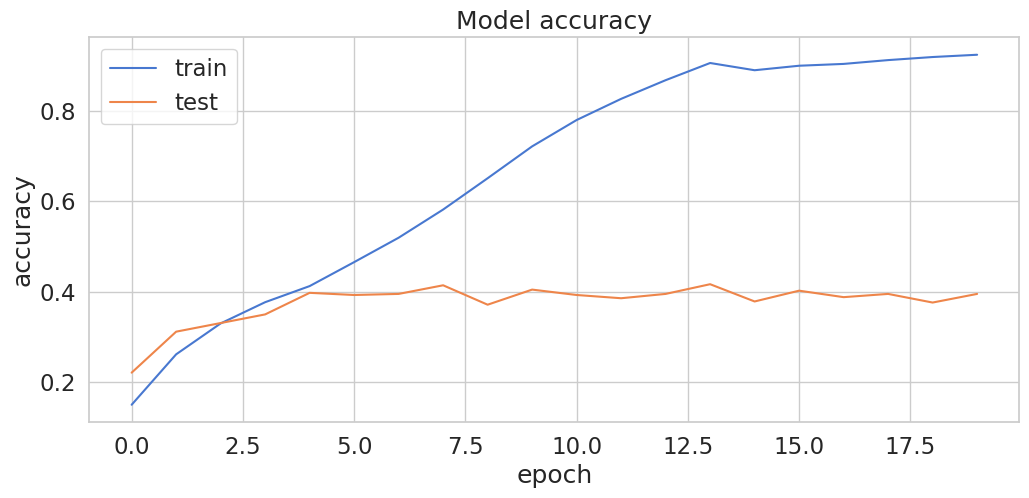

In [227]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


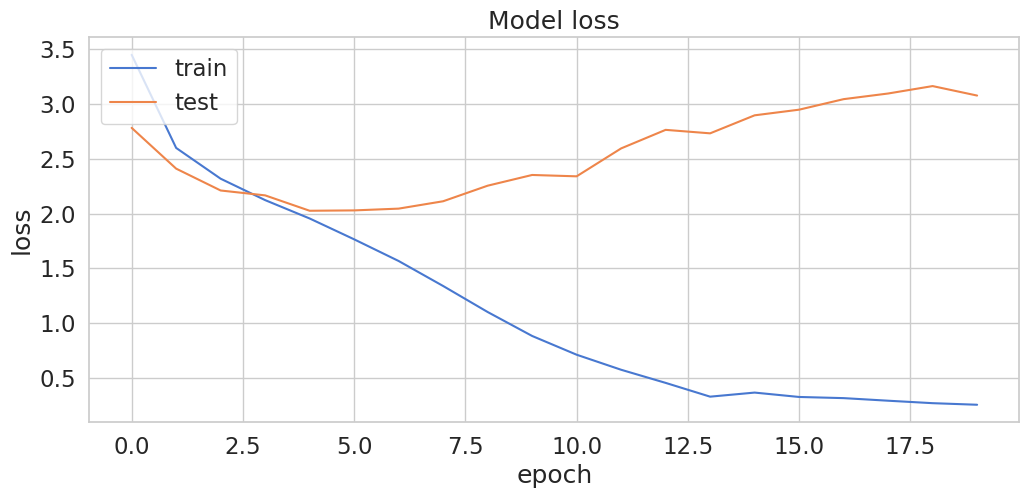

In [228]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

## Step 10:- Model Testing

In [229]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.

    return x


prepare_input("This is an example of input for our LSTM".lower())
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)

    return heapq.nlargest(top_n, range(len(preds)), preds.take)
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

## Step 11:- Predict Next Word

In [230]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!"
]
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['some ', 'reading ', 'gromm ', 'his ', 'fird ']

that which does not kill us makes us str
['e ', "ang.\n'his ", 'ongh ', 'y ', 'ing ']

i'm not upset that you lied to me, i'm u
['sing ', 'nicul ', 'dered ', 'tered ', 'pmands, ']

and those who were seen dancing were tho
['sgros ', 'm ', 'w ', ' glose ', 't ']

it is hard enough to remember my opinion
[' of\nfrechibg ', 'ately ', 's ', '. ', 'er ']



In [231]:
boolx="N"

while boolx!="Y":
    try:
        seq=input("Enter Sometbing: ")
    except:
        seq="It is not a lack of love, but a lack of"

    print(predict_completions(seq, 5))

    boolx=input("To Exit Press : (Y)")

Enter Sometbing:  i am doing my work so you should


['a ', 'iaai ', ',iiiiiii ', 'yiirsiiiiiiticpiiiii-e ', 'u ']


To Exit Press : (Y) Y
